In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO(conv_num=1):
    channel_size = 32
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same', 
                  activation='relu')) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))         
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         3104      
_________________________________________________________________
flatten (Flatten)            (None, 512000)            0         
_________________________________________________________________
dropout (Dropout)            (None, 512000)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                8192016   
Total params: 8,195,248
Trainable params: 8,195,248
Non-trainable params: 0
___________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 5333, 32)          3104      
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 5333, 32)          3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 5333, 32)          3104      
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 5333, 32)          3104      
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4341 - acc: 0.2012
Epoch 00001: val_loss improved from inf to 1.96005, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_4_conv_checkpoint/001-1.9600.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 2.4340 - acc: 0.2012 - val_loss: 1.9600 - val_acc: 0.3722
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8028 - acc: 0.4134
Epoch 00002: val_loss improved from 1.96005 to 1.60336, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_4_conv_checkpoint/002-1.6034.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.8029 - acc: 0.4134 - val_loss: 1.6034 - val_acc: 0.4691
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5568 - acc: 0.5017
Epoch 00003: val_loss improved from 1.60336 to 1.

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2340 - acc: 0.9215
Epoch 00054: val_loss did not improve from 1.09735
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2340 - acc: 0.9215 - val_loss: 1.3580 - val_acc: 0.7100
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2257 - acc: 0.9243
Epoch 00055: val_loss did not improve from 1.09735
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2257 - acc: 0.9243 - val_loss: 1.3427 - val_acc: 0.7000
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2229 - acc: 0.9260
Epoch 00056: val_loss did not improve from 1.09735
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2229 - acc: 0.9260 - val_loss: 1.3157 - val_acc: 0.7049
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2240 - acc: 0.9255
Epoch 00057: val_loss did not improve from 1.09735
36805/36805 [===========

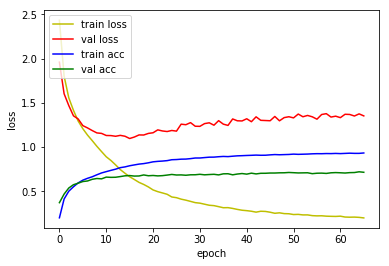

4815/4815 [==============================] - 2s 489us/sample - loss: 1.1753 - acc: 0.6438
Loss: 1.1752867400212947 Accuracy: 0.6438214

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4382 - acc: 0.2060
Epoch 00001: val_loss improved from inf to 1.80592, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_5_conv_checkpoint/001-1.8059.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.4381 - acc: 0.2061 - val_loss: 1.8059 - val_acc: 0.4323
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6761 - acc: 0.4586
Epoch 00002: val_loss improved from 1.80592 to 1.59064, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_5_conv_checkpoint/002-1.5906.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.6762 - acc: 0.4586 - val_loss: 1.5906 - val_acc: 0.4868
Epoch 3/500
36800/36805 [============================>.] 

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5243 - acc: 0.8392
Epoch 00023: val_loss did not improve from 0.74959
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.5243 - acc: 0.8392 - val_loss: 0.7575 - val_acc: 0.7866
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5022 - acc: 0.8456
Epoch 00024: val_loss did not improve from 0.74959
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.5022 - acc: 0.8456 - val_loss: 0.7849 - val_acc: 0.7834
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4796 - acc: 0.8518
Epoch 00025: val_loss did not improve from 0.74959
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.4796 - acc: 0.8519 - val_loss: 0.7521 - val_acc: 0.7906
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4695 - acc: 0.8529
Epoch 00026: val_loss improved from 0.74959 to 0.73960, saving model to mod

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2308 - acc: 0.9239
Epoch 00052: val_loss did not improve from 0.73650
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.2308 - acc: 0.9239 - val_loss: 0.8012 - val_acc: 0.8178
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2306 - acc: 0.9243
Epoch 00053: val_loss did not improve from 0.73650
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2306 - acc: 0.9243 - val_loss: 0.8405 - val_acc: 0.8111
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2298 - acc: 0.9259
Epoch 00054: val_loss did not improve from 0.73650
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.2298 - acc: 0.9259 - val_loss: 0.8396 - val_acc: 0.8125
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2193 - acc: 0.9285
Epoch 00055: val_loss did not improve from 0.73650
36805/36805 [===========

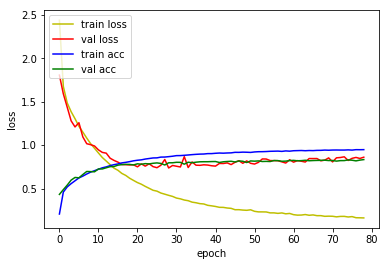

4815/4815 [==============================] - 2s 501us/sample - loss: 0.8568 - acc: 0.7601
Loss: 0.8567534625963507 Accuracy: 0.7601246

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5785 - acc: 0.1427
Epoch 00001: val_loss improved from inf to 2.07253, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_6_conv_checkpoint/001-2.0725.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 2.5785 - acc: 0.1426 - val_loss: 2.0725 - val_acc: 0.3303
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8758 - acc: 0.3762
Epoch 00002: val_loss improved from 2.07253 to 1.53205, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_6_conv_checkpoint/002-1.5321.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.8758 - acc: 0.3762 - val_loss: 1.5321 - val_acc: 0.5111
Epoch 3/500
36800/36805 [============================>.] 

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5549 - acc: 0.8303
Epoch 00023: val_loss improved from 0.53383 to 0.53025, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_6_conv_checkpoint/023-0.5302.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.5550 - acc: 0.8303 - val_loss: 0.5302 - val_acc: 0.8467
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5315 - acc: 0.8390
Epoch 00024: val_loss improved from 0.53025 to 0.49122, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_6_conv_checkpoint/024-0.4912.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.5314 - acc: 0.8391 - val_loss: 0.4912 - val_acc: 0.8581
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5136 - acc: 0.8444
Epoch 00025: val_loss did not improve from 0.49122
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.5136 - acc: 0.84

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2726 - acc: 0.9136
Epoch 00049: val_loss improved from 0.38160 to 0.36956, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_6_conv_checkpoint/049-0.3696.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2725 - acc: 0.9137 - val_loss: 0.3696 - val_acc: 0.9075
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2727 - acc: 0.9156
Epoch 00050: val_loss did not improve from 0.36956
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2727 - acc: 0.9156 - val_loss: 0.3763 - val_acc: 0.9075
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2650 - acc: 0.9156
Epoch 00051: val_loss improved from 0.36956 to 0.36187, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_6_conv_checkpoint/051-0.3619.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2651 - acc: 0.91

Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1828 - acc: 0.9411
Epoch 00077: val_loss did not improve from 0.35006
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1828 - acc: 0.9411 - val_loss: 0.3772 - val_acc: 0.9210
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1799 - acc: 0.9414
Epoch 00078: val_loss did not improve from 0.35006
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1799 - acc: 0.9414 - val_loss: 0.3701 - val_acc: 0.9178
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1738 - acc: 0.9425
Epoch 00079: val_loss did not improve from 0.35006
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1738 - acc: 0.9425 - val_loss: 0.3657 - val_acc: 0.9171
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1739 - acc: 0.9423
Epoch 00080: val_loss did not improve from 0.35006
36805/36805 [===========

Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1076 - acc: 0.9640
Epoch 00136: val_loss did not improve from 0.34778
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1077 - acc: 0.9640 - val_loss: 0.3877 - val_acc: 0.9199
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1073 - acc: 0.9638
Epoch 00137: val_loss did not improve from 0.34778
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1074 - acc: 0.9638 - val_loss: 0.3822 - val_acc: 0.9241
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1159 - acc: 0.9624
Epoch 00138: val_loss did not improve from 0.34778
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1159 - acc: 0.9624 - val_loss: 0.3585 - val_acc: 0.9257
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1027 - acc: 0.9660
Epoch 00139: val_loss did not improve from 0.34778
36805/36805 [=======

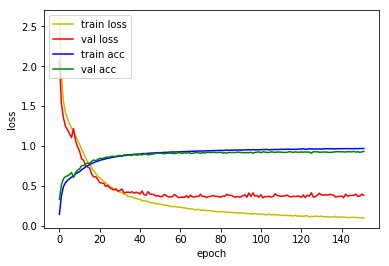

4815/4815 [==============================] - 3s 543us/sample - loss: 0.4141 - acc: 0.8910
Loss: 0.4140792941131077 Accuracy: 0.89096576

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6965 - acc: 0.0925
Epoch 00001: val_loss improved from inf to 2.51387, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_7_conv_checkpoint/001-2.5139.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 2.6964 - acc: 0.0925 - val_loss: 2.5139 - val_acc: 0.1794
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1497 - acc: 0.2882
Epoch 00002: val_loss improved from 2.51387 to 1.55297, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_7_conv_checkpoint/002-1.5530.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 2.1495 - acc: 0.2882 - val_loss: 1.5530 - val_acc: 0.4899
Epoch 3/500
36800/36805 [============================>.]

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5465 - acc: 0.8292
Epoch 00023: val_loss improved from 0.45652 to 0.42751, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_7_conv_checkpoint/023-0.4275.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.5464 - acc: 0.8292 - val_loss: 0.4275 - val_acc: 0.8712
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5277 - acc: 0.8359
Epoch 00024: val_loss did not improve from 0.42751
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.5277 - acc: 0.8359 - val_loss: 0.4445 - val_acc: 0.8668
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5080 - acc: 0.8418
Epoch 00025: val_loss improved from 0.42751 to 0.39403, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_7_conv_checkpoint/025-0.3940.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.5080 - acc: 0.84

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2882 - acc: 0.9089
Epoch 00047: val_loss did not improve from 0.24085
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2882 - acc: 0.9088 - val_loss: 0.2425 - val_acc: 0.9280
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2894 - acc: 0.9079
Epoch 00048: val_loss did not improve from 0.24085
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2894 - acc: 0.9079 - val_loss: 0.2490 - val_acc: 0.9238
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2787 - acc: 0.9104
Epoch 00049: val_loss did not improve from 0.24085
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2787 - acc: 0.9103 - val_loss: 0.2458 - val_acc: 0.9350
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2778 - acc: 0.9125
Epoch 00050: val_loss improved from 0.24085 to 0.23821, saving model to mod

36800/36805 [============================>.] - ETA: 0s - loss: 0.1491 - acc: 0.9513
Epoch 00101: val_loss did not improve from 0.17905
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1492 - acc: 0.9512 - val_loss: 0.1953 - val_acc: 0.9446
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1486 - acc: 0.9506
Epoch 00102: val_loss did not improve from 0.17905
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1486 - acc: 0.9506 - val_loss: 0.1828 - val_acc: 0.9476
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1433 - acc: 0.9527
Epoch 00103: val_loss did not improve from 0.17905
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1432 - acc: 0.9527 - val_loss: 0.2027 - val_acc: 0.9483
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1426 - acc: 0.9534
Epoch 00104: val_loss did not improve from 0.17905
36805/36805 [=====================

Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1153 - acc: 0.9608
Epoch 00131: val_loss did not improve from 0.17905
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1152 - acc: 0.9608 - val_loss: 0.1941 - val_acc: 0.9550
Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1136 - acc: 0.9629
Epoch 00132: val_loss did not improve from 0.17905
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1135 - acc: 0.9629 - val_loss: 0.1849 - val_acc: 0.9543
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1119 - acc: 0.9621
Epoch 00133: val_loss improved from 0.17905 to 0.17881, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_7_conv_checkpoint/133-0.1788.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1119 - acc: 0.9621 - val_loss: 0.1788 - val_acc: 0.9534
Epoch 134/500
36800/36805 [============================>.] - ET

Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0936 - acc: 0.9677
Epoch 00160: val_loss improved from 0.17808 to 0.17798, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_7_conv_checkpoint/160-0.1780.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0936 - acc: 0.9677 - val_loss: 0.1780 - val_acc: 0.9571
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0947 - acc: 0.9673
Epoch 00161: val_loss did not improve from 0.17798
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0947 - acc: 0.9673 - val_loss: 0.2128 - val_acc: 0.9543
Epoch 162/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0911 - acc: 0.9682
Epoch 00162: val_loss did not improve from 0.17798
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.0911 - acc: 0.9682 - val_loss: 0.1857 - val_acc: 0.9560
Epoch 163/500
36800/36805 [============================>.] - ET

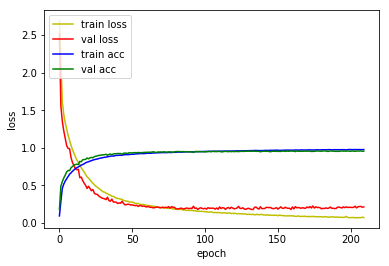

4815/4815 [==============================] - 3s 567us/sample - loss: 0.1959 - acc: 0.9456
Loss: 0.1959358832523273 Accuracy: 0.9455867

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6519 - acc: 0.1134
Epoch 00001: val_loss improved from inf to 2.35360, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_8_conv_checkpoint/001-2.3536.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 2.6519 - acc: 0.1134 - val_loss: 2.3536 - val_acc: 0.2364
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1326 - acc: 0.2992
Epoch 00002: val_loss improved from 2.35360 to 1.55364, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_8_conv_checkpoint/002-1.5536.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.1325 - acc: 0.2992 - val_loss: 1.5536 - val_acc: 0.5155
Epoch 3/500
36800/36805 [============================>.] 

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2501 - acc: 0.9208
Epoch 00047: val_loss did not improve from 0.18897
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2500 - acc: 0.9208 - val_loss: 0.1949 - val_acc: 0.9457
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2440 - acc: 0.9223
Epoch 00048: val_loss improved from 0.18897 to 0.17913, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_8_conv_checkpoint/048-0.1791.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2440 - acc: 0.9223 - val_loss: 0.1791 - val_acc: 0.9485
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2403 - acc: 0.9238
Epoch 00049: val_loss did not improve from 0.17913
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2402 - acc: 0.9238 - val_loss: 0.1862 - val_acc: 0.9481
Epoch 50/500
36800/36805 [============================>.] - ETA: 0

Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1588 - acc: 0.9480
Epoch 00073: val_loss improved from 0.14752 to 0.14620, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_8_conv_checkpoint/073-0.1462.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1588 - acc: 0.9480 - val_loss: 0.1462 - val_acc: 0.9581
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1539 - acc: 0.9489
Epoch 00074: val_loss did not improve from 0.14620
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1539 - acc: 0.9489 - val_loss: 0.1582 - val_acc: 0.9569
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1561 - acc: 0.9493
Epoch 00075: val_loss did not improve from 0.14620
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1561 - acc: 0.9493 - val_loss: 0.1537 - val_acc: 0.9553
Epoch 76/500
36800/36805 [============================>.] - ETA: 0

Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1064 - acc: 0.9638
Epoch 00101: val_loss did not improve from 0.13231
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1064 - acc: 0.9638 - val_loss: 0.1336 - val_acc: 0.9660
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1078 - acc: 0.9638
Epoch 00102: val_loss did not improve from 0.13231
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1078 - acc: 0.9638 - val_loss: 0.1393 - val_acc: 0.9646
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1051 - acc: 0.9639
Epoch 00103: val_loss improved from 0.13231 to 0.13056, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_8_conv_checkpoint/103-0.1306.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1051 - acc: 0.9639 - val_loss: 0.1306 - val_acc: 0.9655
Epoch 104/500
36800/36805 [============================>.] - ET

Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0812 - acc: 0.9727
Epoch 00130: val_loss did not improve from 0.12915
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0812 - acc: 0.9727 - val_loss: 0.1524 - val_acc: 0.9665
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0799 - acc: 0.9723
Epoch 00131: val_loss did not improve from 0.12915
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0802 - acc: 0.9723 - val_loss: 0.1544 - val_acc: 0.9637
Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0820 - acc: 0.9723
Epoch 00132: val_loss did not improve from 0.12915
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0820 - acc: 0.9723 - val_loss: 0.1532 - val_acc: 0.9681
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0778 - acc: 0.9733
Epoch 00133: val_loss did not improve from 0.12915
36805/36805 [=======

Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0630 - acc: 0.9780
Epoch 00160: val_loss did not improve from 0.12915
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0630 - acc: 0.9780 - val_loss: 0.1394 - val_acc: 0.9662
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0577 - acc: 0.9801
Epoch 00161: val_loss did not improve from 0.12915
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0577 - acc: 0.9801 - val_loss: 0.1589 - val_acc: 0.9634

1D_CNN_custom_conv_3_VGG_ch_32_DO_8_conv Model


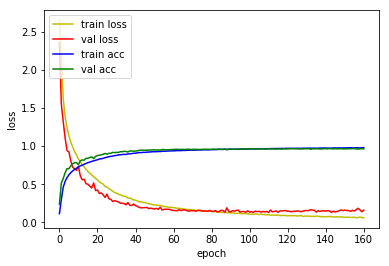

4815/4815 [==============================] - 3s 579us/sample - loss: 0.1792 - acc: 0.9481
Loss: 0.1792294374352799 Accuracy: 0.94807893

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4881 - acc: 0.1809
Epoch 00001: val_loss improved from inf to 1.93513, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_9_conv_checkpoint/001-1.9351.hdf5
36805/36805 [==============================] - 59s 2ms/sample - loss: 2.4880 - acc: 0.1810 - val_loss: 1.9351 - val_acc: 0.3958
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8247 - acc: 0.4126
Epoch 00002: val_loss improved from 1.93513 to 1.39202, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_9_conv_checkpoint/002-1.3920.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 1.8248 - acc: 0.4126 - val_loss: 1.3920 - val_acc: 0.5537
Epoch 3/500
36800/36805 [============================>.]

36800/36805 [============================>.] - ETA: 0s - loss: 0.1677 - acc: 0.9433
Epoch 00048: val_loss did not improve from 0.20035
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1677 - acc: 0.9433 - val_loss: 0.2172 - val_acc: 0.9338
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1672 - acc: 0.9430
Epoch 00049: val_loss did not improve from 0.20035
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1672 - acc: 0.9429 - val_loss: 0.2045 - val_acc: 0.9373
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1682 - acc: 0.9436
Epoch 00050: val_loss improved from 0.20035 to 0.19942, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_9_conv_checkpoint/050-0.1994.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1682 - acc: 0.9436 - val_loss: 0.1994 - val_acc: 0.9380
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1

36800/36805 [============================>.] - ETA: 0s - loss: 0.0927 - acc: 0.9677
Epoch 00075: val_loss did not improve from 0.17801
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0927 - acc: 0.9677 - val_loss: 0.1998 - val_acc: 0.9497
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0920 - acc: 0.9681
Epoch 00076: val_loss did not improve from 0.17801
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0920 - acc: 0.9681 - val_loss: 0.2024 - val_acc: 0.9497
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0886 - acc: 0.9691
Epoch 00077: val_loss did not improve from 0.17801
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0886 - acc: 0.9691 - val_loss: 0.1898 - val_acc: 0.9481
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0870 - acc: 0.9699
Epoch 00078: val_loss did not improve from 0.17801
36805/36805 [========================


1D_CNN_custom_conv_3_VGG_ch_32_DO_9_conv Model


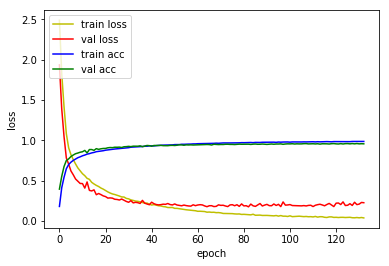

4815/4815 [==============================] - 3s 610us/sample - loss: 0.2719 - acc: 0.9302
Loss: 0.27185838637972176 Accuracy: 0.93021804



In [10]:
base = '1D_CNN_custom_conv_3_VGG_ch_32_DO'
    
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [8]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_ch_32_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_32_DO_4_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 32)          0 

4815/4815 [==============================] - 3s 541us/sample - loss: 0.4141 - acc: 0.8910
Loss: 0.4140792941131077 Accuracy: 0.89096576

1D_CNN_custom_conv_3_VGG_ch_32_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_124 (Conv1D)     

4815/4815 [==============================] - 3s 602us/sample - loss: 0.2719 - acc: 0.9302
Loss: 0.27185838637972176 Accuracy: 0.93021804


In [9]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_32_DO_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 5333, 32)          3104      
_________________________________________________________________
conv1d_95 (Conv1D)          

4815/4815 [==============================] - 3s 629us/sample - loss: 0.4269 - acc: 0.9022
Loss: 0.4269444535918696 Accuracy: 0.9021807

1D_CNN_custom_conv_3_VGG_ch_32_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_124 (Conv1D)      

4815/4815 [==============================] - 3s 675us/sample - loss: 0.3246 - acc: 0.9389
Loss: 0.32459399479568035 Accuracy: 0.9389408
